# AST/STAT 5731 Project 3

Group 5: Darya Biparva, Xiaoxiao Kou, John Miller Jr, Sam Penders

## Introduction

Gamma-ray bursts (GRBs) are short duration, highly energetic electromagnetic radiation that are detected from extragalactic sources. The nature of GRBs, i.e. how they are produced, where they are produced, etc., is not currently known. However, there seems to be at least two different classes of GRBs, which was first discovered and published in Meegan et al. 1993: short events (< 2s) and longer ones (> 2s). The duration of these events are defined to be 'the time during which the cumulative counts increase from 5% to 95% above background, thus encompassing 90% of the total GRB counts,' and is called 'T90'. A similar definintion is applied for the T50 duration. A bimodal distribution is revealed when plotting a histogram of numerous log(T90) observations (short and long GRBs). Therefore, the distribution of GRB T90s follow a bimodal lognormal distribution. 

Figure 1 (Below): The T90 distribution found in Meegan et al. 1993. 

In [1]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/image.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

ModuleNotFoundError: No module named 'google'

Our main research goal is to determine how the bimodal distribution parameters of GRBs from previous observations change with new GRB observations. Narrowing the estimated bimodal distributions of these classes will allow for a more robust analysis and determination of astronomical processes that could be generating these GRBs.

References:
> 
> 
> 



---



## Statistical model

> $N = \mathrm{\#\, Observations} $
> 
> $i \in \{1, 2, \dots, N\}$
>
> $f_Y(y) = w_s f_s(y \,\vert\, \mu_s, \rho_s) + w_l f_l(y \,\vert\, \mu_l, \rho_l) $
> 
> $(w_s, w_l) \sim \mathrm{Dirichlet}_2(p_1, p_2)$
>
> $z_i \,\vert\, w_s, w_l \sim \mathrm{Categorical}(w_s, w_l)$
>
> $\mu_s \sim \mathrm{Normal}(m_s, s_s)$
> 
> $\mu_l \sim \mathrm{Normal}(m_l, s_l)$
> 
> $\sigma_s \sim \mathrm{Gamma}(a_s, b_s)$
>
> $\sigma_l \sim \mathrm{Gamma}(a_l, b_l)$

We parametized the Gamma distributions in terms of their mean $a$ and standard deviation $b$. $f_j(y \,\vert\, \mu_j, \sigma_j)$ is the lognormal density for each component $j \in \{s, l\}$:
>
> $f_j(y \,\vert\, \mu_j, \sigma_j) = \frac{1}{y \sigma_j \sqrt{2 \pi}} \exp{ \Big( {-\frac{(\ln(y) - \mu_j)^2}{2 \sigma_j^2} \Big) } }$.

## Sample space

> $Y_i \in (0, \infty)$
>
> $(w_s, w_l) \in [0, 1]^2 \,\mathrm{s.t.}\, w_s + w_l = 1$
>
> $z_i \in \{s, l\}$
>
> $\mu_s, \mu_l \in \mathbb{R}$
>
> $\sigma_s, \sigma_l \in (0, \infty)$
> 
## Priors

Our priors are based on results from Ripa et. al. Because the reported values of $\mu, \sigma$ and their standard errors are reported for a base-10 lognormal model, we convert these values to base-$e$ by dividing by a factor of $\log_{10}(e)$. We assume that the values of $\mu$ and $\sigma$ reported by Ripa et. al. followed a normal distribution with standard deviations given by the reported errors, so we can simply transform the mean and standard error for these distributions by dividing by $\log_{10}(e)$.

Thus, our priors are:

> $(m_s, s_s) = (-1.06,  0.30)$
> 
> $(m_l, s_l) = (-2.90, 0.07)$
> 
> $(a_s, b_s)= (1.38, 0.14)$
> 
> $(a_l, b_l) = (0.97, 0.02)$
>
> $(w_s, w_l) = (0.19, 0.81)$

## Analysis

In [2]:
import pandas as pd
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr

! pip install watermark
! pip install corner
import corner
import watermark

%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Dec 15 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

xarray: 2022.10.0

pymc      : 4.3.0
matplotlib: 3.6.2
pandas    : 1.5.1
seaborn   : 0.12.1
astropy   : 5.1.1
arviz     : 0.13.0
xarray    : 2022.10.0
watermark : 2.3.1
corner    : 2.2.1
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
numpy     : 1.23.4

Watermark: 2.3.1



In [3]:
# print library versions used
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Dec 15 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

xarray: 2022.10.0

pymc      : 4.3.0
matplotlib: 3.6.2
pandas    : 1.5.1
seaborn   : 0.12.1
astropy   : 5.1.1
arviz     : 0.13.0
xarray    : 2022.10.0
watermark : 2.3.1
corner    : 2.2.1
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
numpy     : 1.23.4

Watermark: 2.3.1



In [4]:
# importing data from CDS
data = ascii.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJS/223/28/table6.dat", \
                   readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJS/223/28/ReadMe").to_pandas() 

prior_data = ascii.read("https://cdsarc.cds.unistra.fr/ftp/J/A+A/498/399/table7.dat", \
                   readme="https://cdsarc.cds.unistra.fr/ftp/J/A+A/498/399/ReadMe").to_pandas() 

data['logT90'] = np.log(data['T90'])
prior_data['logT90'] = np.log(prior_data['T90'])
data['log10T90'] = np.log10(data['T90'])
prior_data['log10T90'] = np.log10(prior_data['T90'])
y = data['T90']

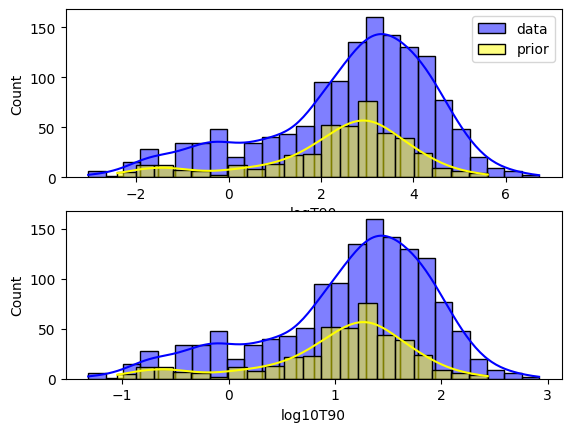

In [5]:
fig, axs = plt.subplots(2, 1)
sns.histplot(data=data, x='logT90', kde=True, ax=axs[0], label='data', color='blue')
sns.histplot(data=prior_data, x='logT90', kde=True, ax=axs[0], label='prior', color='yellow')
sns.histplot(data=data, x='log10T90', kde=True, ax=axs[1], label='data', color='blue')
sns.histplot(data=prior_data, x='log10T90', kde=True, ax=axs[1], label='prior', color='yellow')
axs[0].legend()


 As mentioned previously, we obtained the priors from Ripa et. al. we observe a slight shift in the density. This means that we can potentially get a slightly different result from what was reported in Ripa et. al.
 Also, as mentioned previously, we note that the results reported in Ripa et. al were based on a lognormal distribution that uses $log_{10}$. However, we're using natural logarithm and we have adjusted the priors accordingly. The figure above depicts the difference. The upper figure is the distribution of $log_{\mathcal{e}}(y)$. We can see that the second mean is located between 2 and 4. However, the second figure illustrates the distribution of $log_{10}(y)$. The second mean is located between 1 and 2. 

In [6]:
# Priors
'''
chisq fit from Ripa et al. in 2-mixture model
+/- are standard errors obtained from distribution
of 10 different fitings
These values are in log base 10

mu_short = -0.46 +/- 0.13
sigma_short = 0.60 +/- 0.06
mu_long = 1.26 +/- 0.03
sigma_long = 0.42 +/- 0.01
'''
from math import log10, e

# convert to log base e
mu_short = -0.46 / log10(e)
se_mu_short = 0.13 / log10(e)
sigma_short = 0.60 / log10(e)
se_sigma_short = 0.06 / log10(e)
w_short = 0.187
se_w_short = 0.015 / log10(e)

mu_long = 1.26 / log10(e)
se_mu_long = 0.03 / log10(e)
sigma_long = 0.42 / log10(e)
se_sigma_long = 0.01 / log10(e)
w_long = 0.813
se_w_long = 0.015 / log10(e)

n = len(y)

print('mu_s {:.2f} {:.2f}'.format(mu_short, se_mu_short))
print('mu_l {:.2f} {:.2f}'.format(mu_long, se_mu_long))
print('sigma_s {:.2f} {:.2f}'.format(sigma_short, se_sigma_short))
print('sigma_l {:.2f} {:.2f}'.format(sigma_long, se_sigma_long))
print('w_short, long {:.2f} {:.2f}'.format(w_short, w_long))
print('n', n)

mu_s -1.06 0.30
mu_l 2.90 0.07
sigma_s 1.38 0.14
sigma_l 0.97 0.02
w_short, long 0.19 0.81
n 1405


The transformation $z = \frac{x}{log_{10}(e)}$ is applied to mean and standard deviations in order to get the priors applicable to our analysis (z is the new prior for our case).

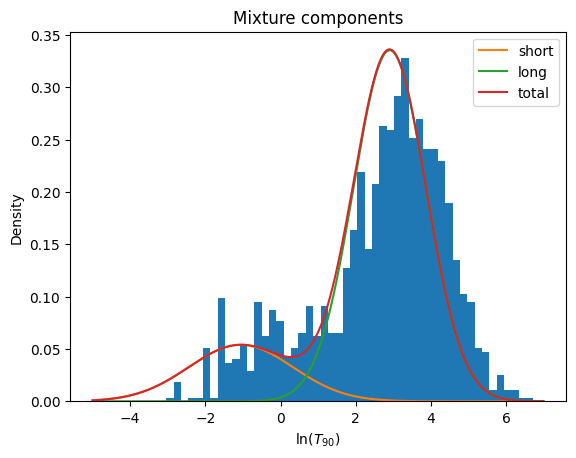

In [7]:
# plot of data and prior mixture components
from scipy.stats import norm
xx = np.arange(-5, 7, 0.01)
y_short = w_short * norm.pdf(xx, loc=mu_short, scale=sigma_short)
y_long = w_long * norm.pdf(xx, loc=mu_long, scale=sigma_long)
y_total = y_short + y_long

fig, ax = plt.subplots()
ax.hist(np.log(y), bins=50, density=True)
ax.plot(xx, y_short, label='short')
ax.plot(xx, y_long, label='long')
ax.plot(xx, y_total, label='total')

ax.set_xlabel(r'$\ln(T_{90})$')
ax.set_ylabel('Density')
ax.set_title('Mixture components')

ax.legend()

Again, we note that the distribution obtained from the priors is slightly different from the empirical distribution of our data.

### Mixture Model

In [8]:
with pm.Model() as model2:
    # mixture weights
    w = pm.Dirichlet('w', a=np.array([w_short, w_long]))


    mu_s = pm.Normal('mu_s', mu=mu_short, sigma=se_mu_short)
    mu_l = pm.Normal('mu_l', mu=mu_long, sigma=se_mu_long)


    sigma_s = pm.Gamma('sigma_s', mu=sigma_short, sigma=se_sigma_short)
    sigma_l = pm.Gamma('sigma_l', mu=sigma_long, sigma=se_sigma_long)

    components = [
        pm.LogNormal.dist(mu=mu_s, sigma=sigma_s),
        pm.LogNormal.dist(mu=mu_l, sigma=sigma_l),
    ]

    y_obs = pm.Mixture('y_obs', w=w, comp_dists=components, observed=y)

    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu_s, mu_l, sigma_s, sigma_l]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_s,-0.309,0.105,-0.509,-0.113,0.002,0.001,3853.0,4582.0,1.0
mu_l,3.259,0.035,3.194,3.322,0.001,0.000,4413.0,5582.0,1.0
w[0],0.201,0.014,0.174,0.227,0.000,0.000,4259.0,5045.0,1.0
w[1],0.799,0.014,0.773,0.826,0.000,0.000,4259.0,5045.0,1.0
sigma_s,1.172,0.067,1.049,1.298,0.001,0.001,4708.0,5595.0,1.0
sigma_l,1.030,0.018,0.995,1.064,0.000,0.000,5521.0,5796.0,1.0


The table above shows our bayesian estimates of the parameters. As expected the means are slightly different from the ones reported in Ripa et. al.

array([[<AxesSubplot: title={'center': 'mu_s'}>,
        <AxesSubplot: title={'center': 'mu_s'}>],
       [<AxesSubplot: title={'center': 'mu_l'}>,
        <AxesSubplot: title={'center': 'mu_l'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'sigma_s'}>,
        <AxesSubplot: title={'center': 'sigma_s'}>],
       [<AxesSubplot: title={'center': 'sigma_l'}>,
        <AxesSubplot: title={'center': 'sigma_l'}>]], dtype=object)

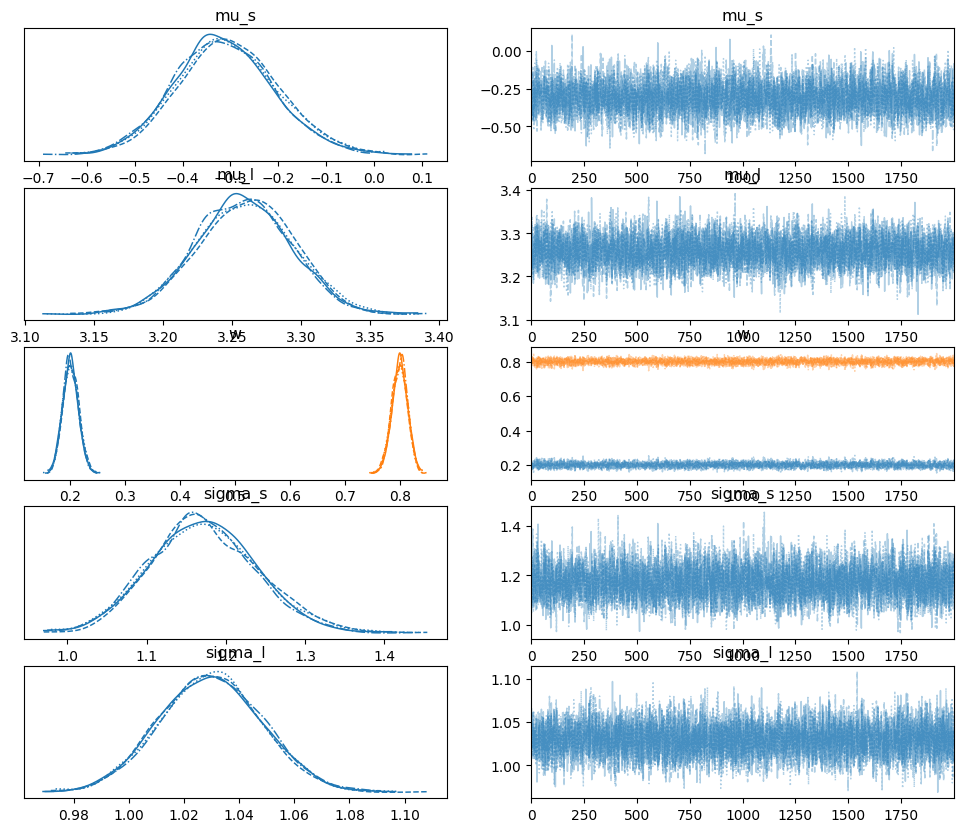

In [10]:
az.plot_trace(trace)

The figures above depict the results of using NUTS sampler. The figures seem reasonable. We do not observe correlation between samples (Since it looks like white noise). In order to further test the credibility of our bayesian analysis, we will conduct the following tests:
> Prior predictive check
>
> ACF plot analysis
>
> Posterior predictive check
>
>Sensitivity analysis

## Prior Predictive Check

In [ ]:
# prior predictive
with model2:
    priortrace = pm.sample_prior_predictive(300, model=model2)

In [ ]:
priortrace.prior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 3000, w_dim_0: 2)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
  * w_dim_0  (w_dim_0) int64 0 1
Data variables:
    sigma_s  (chain, draw) float64 1.3 1.418 1.568 1.48 ... 1.463 1.553 1.406
    w        (chain, draw, w_dim_0) float64 0.2383 0.7617 ... 2.998e-05 1.0
    sigma_l  (chain, draw) float64 0.9475 0.986 1.018 ... 0.9387 0.9847 0.9832
    mu_l     (chain, draw) float64 2.917 2.955 2.879 2.751 ... 2.92 2.897 2.962
    mu_s     (chain, draw) float64 -0.8894 -1.071 -1.07 ... -0.5203 -0.7152
Attributes:
    created_at:                 2022-12-15T17:40:38.043107
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4

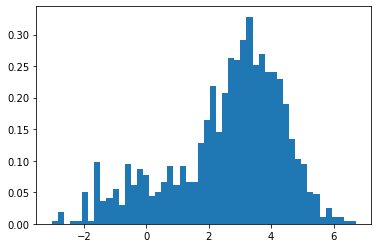

In [ ]:
# prior predictive
plt.hist(np.log(trace.observed_data['y_obs'].values), bins=50, density=True);

# ACF Plots

In [11]:
pm.Matplot.autocorrelations(trace)

AttributeError: module 'pymc' has no attribute 'Matplot'

In [ ]:
with model2:
    ppc = pm.sample_posterior_predictive(trace=trace)

In [ ]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

(array([ 1.,  0.,  1.,  0.,  2.,  0.,  0.,  2.,  1.,  3.,  3.,  4.,  3.,
         2.,  1.,  4.,  6.,  2.,  7., 10.,  7., 10.,  5.,  8., 10.,  9.,
        13., 11.,  5.,  8., 17.,  9., 11.,  7., 12., 14., 13., 11.,  8.,
         8., 10., 11., 15.,  9.,  6., 11., 10.,  8., 17., 15., 15., 21.,
        18., 19., 20., 32., 31., 39., 36., 39., 43., 40., 36., 53., 34.,
        52., 37., 34., 62., 43., 33., 33., 31., 36., 21., 26., 22., 19.,
        24., 17., 18.,  8.,  6., 10.,  9.,  7.,  7.,  1.,  3.,  1.,  4.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]),
 array([-1.57396863, -1.52827974, -1.48259085, -1.43690197, -1.39121308,
        -1.34552419, -1.29983531, -1.25414642, -1.20845753, -1.16276865,
        -1.11707976, -1.07139087, -1.02570198, -0.9800131 , -0.93432421,
        -0.88863532, -0.84294644, -0.79725755, -0.75156866, -0.70587978,
        -0.66019089, -0.614502  , -0.56881312, -0.52312423, -0.47743534,
        -0.43174646, -0.38605757, -0.34036868, -0.2946798 , -0.248990

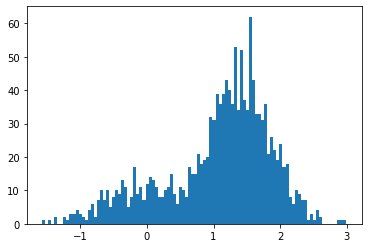

In [ ]:
ppc_y = ppc.posterior_predictive['y_obs'].values
plt.hist(np.log10(ppc_y[0,0,:]), bins=100)

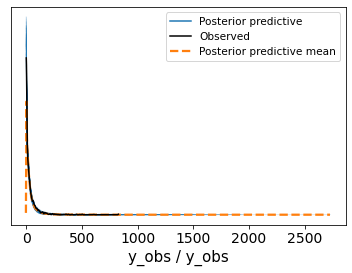

In [ ]:
az.plot_ppc(ppc, num_pp_samples=100);

## Sensitivity Analysis

In [ ]:
k=2
y_data = y

with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means1 = pm.Normal('means1',mu=-1, tau=1e-3)
    means2 = pm.Normal('means2',mu=1, tau=1e-3)
    sigma1 = pm.Gamma('sigma1',alpha=7.5, beta=1)
    sigma2 = pm.Gamma('sigma2',alpha=7.5, beta=1)
    components = [
        pm.LogNormal.dist(mu=means1, sigma=sigma1),
        pm.LogNormal.dist(mu=means2, sigma=sigma2),
    ]


    y_obs = pm.Mixture('y_obs', w=w, comp_dists=components, observed=y)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

I'm am adding my analysis here (a draft)(Darya)

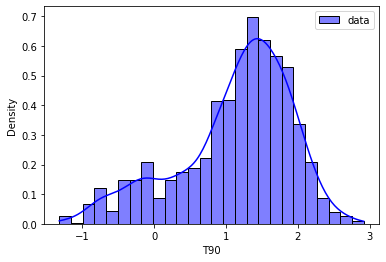

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=data, x=np.log10(y), kde=True, ax=ax, label='data', color='blue', stat='density')
#sns.histplot(data=prior_data, x='logT90', kde=True, ax=ax, label='prior', color='green', stat='density')
ax.legend()

TypeError: ignored

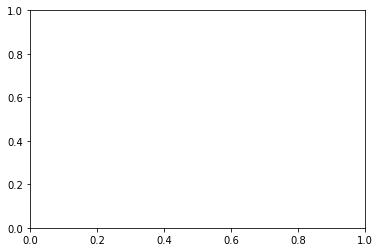

In [ ]:
from scipy.stats import gamma
a = 1.99
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = gamma.stats(0.5,0.5, moments='mvsk')
x = np.linspace(gamma.ppf(0.01, a),
                gamma.ppf(0.99, a), 100)
ax.plot(x, gamma.pdf(x, a),
       'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.show()

In [ ]:
k=2
y_data = y
with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means1 = pm.Normal('means1',mu=-1, tau=1e-3)
    means2 = pm.Normal('means2',mu=1, tau=1e-3)
    sigma1 = pm.Gamma('sigma1',alpha=7.5, beta=1)
    sigma2 = pm.Gamma('sigma2',alpha=7.5, beta=1)
    components = [
        pm.LogNormal.dist(mu=means1, sigma=sigma1),
        pm.LogNormal.dist(mu=means2, sigma=sigma2),
    ]


    y_obs = pm.Mixture('y_obs', w=w, comp_dists=components, observed=y)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

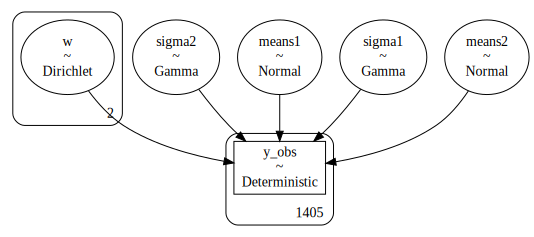

In [ ]:
pm.model_to_graphviz(mixture)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66789ea5b0>,
      dtype=object)

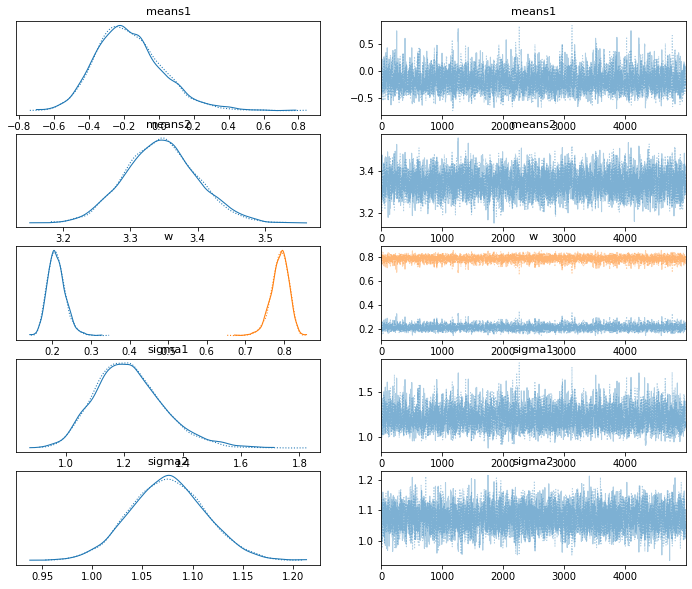

In [ ]:
az.plot_trace(trace_out)
plt.tight_layout()

In [ ]:
az.summary(trace_out)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means1,-0.170,0.192,-0.511,0.190,0.004,0.003,2768.0,3292.0,1.0
means2,3.346,0.054,3.242,3.443,0.001,0.001,3247.0,4324.0,1.0
w[0],0.211,0.023,0.168,0.253,0.000,0.000,2900.0,3478.0,1.0
w[1],0.789,0.023,0.747,0.832,0.000,0.000,2900.0,3478.0,1.0
sigma1,1.217,0.118,1.013,1.449,0.002,0.002,2914.0,3904.0,1.0
sigma2,1.075,0.037,1.008,1.148,0.001,0.000,3484.0,4650.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6685c34f70>,
      dtype=object)

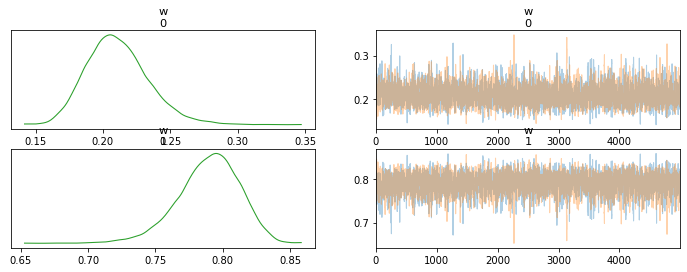

In [ ]:
az.plot_trace(trace_out,['w'],combined=True,compact=False)